### **0. Library**

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### **1. Data Load**

In [2]:
# 데이터 로드

train_path = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/train.csv'
test_path  = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [3]:
# 문자열 변경을 위한 re import
import re

key_list = {}

for text in list(train.columns):
    # '전용면적별세대현황'으로 시작하면 괄호 제거 안함
    if text.startswith('k-전용면적별세대'): # 그냥 괄호를 제거하면 중복된 이름이 발생하기 때문에 처리한 예외 처리 
        cleaned = re.sub(r'^k-', '', text).strip()

    else :
        cleaned = re.sub(r'\(.*?\)','',text)
        cleaned = re.sub(r'^k-','',cleaned)
        cleaned = cleaned.strip()
    key_list[text] = cleaned
print(key_list)

train = train.rename(columns = key_list)
test = test.rename(columns = key_list)

{'시군구': '시군구', '번지': '번지', '본번': '본번', '부번': '부번', '아파트명': '아파트명', '전용면적(㎡)': '전용면적', '계약년월': '계약년월', '계약일': '계약일', '층': '층', '건축년도': '건축년도', '도로명': '도로명', '해제사유발생일': '해제사유발생일', '등기신청일자': '등기신청일자', '거래유형': '거래유형', '중개사소재지': '중개사소재지', 'k-단지분류(아파트,주상복합등등)': '단지분류', 'k-전화번호': '전화번호', 'k-팩스번호': '팩스번호', '단지소개기존clob': '단지소개기존clob', 'k-세대타입(분양형태)': '세대타입', 'k-관리방식': '관리방식', 'k-복도유형': '복도유형', 'k-난방방식': '난방방식', 'k-전체동수': '전체동수', 'k-전체세대수': '전체세대수', 'k-건설사(시공사)': '건설사', 'k-시행사': '시행사', 'k-사용검사일-사용승인일': '사용검사일-사용승인일', 'k-연면적': '연면적', 'k-주거전용면적': '주거전용면적', 'k-관리비부과면적': '관리비부과면적', 'k-전용면적별세대현황(60㎡이하)': '전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)': '전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하': '85㎡~135㎡이하', 'k-135㎡초과': '135㎡초과', 'k-홈페이지': '홈페이지', 'k-등록일자': '등록일자', 'k-수정일자': '수정일자', '고용보험관리번호': '고용보험관리번호', '경비비관리형태': '경비비관리형태', '세대전기계약방법': '세대전기계약방법', '청소비관리형태': '청소비관리형태', '건축면적': '건축면적', '주차대수': '주차대수', '기타/의무/임대/임의=1/2/3/4': '기타/의무/임대/임의=1/2/3/4', '단지승인일': '단지승인일', '사용허가여부': '사용허가여부', '관리비 업로드': '관리비 업로드

In [4]:
# Data pre-processing

## is_test : train/test 구분을 위한 변수
## concat을 통한 train, test 합쳐주기

train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

print(concat.shape)
print(concat['is_test'].value_counts())

(1128094, 53)
0    1118822
1       9272
Name: is_test, dtype: int64


In [5]:
# 결측치는 아닌데 의미 없는 형식적 값 찾는 함수

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            val_counts = df[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

# 아무 의미 없는 값 결측처리를 위해 nan으로 변경
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64

🔎 시행사 컬럼에서 의미 없는 값 발견:
.    868
-    152
Name: 시행사, dtype: int64

🔎 홈페이지 컬럼에서 의미 없는 값 발견:
없음    3628
.       72
Name: 홈페이지, dtype: int64



In [6]:
# 결측률 30% 이상 삭제
concat.drop(axis = 1, columns = list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]), inplace=True)

In [7]:
# categorical column name, numerical column name return function
def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

# update and check variable
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']


In [8]:
concat.drop(axis = 1, columns=['본번', '부번', '계약일', '번지', '아파트명', '도로명'])

,시군구,전용면적,계약년월,층,건축년도,target,is_test
0,서울특별시 강남구 개포동,79.97,201712,3,1987,124000.0,0
1,서울특별시 강남구 개포동,79.97,201712,4,1987,123500.0,0
2,서울특별시 강남구 개포동,54.98,201712,5,1987,91500.0,0
3,서울특별시 강남구 개포동,79.97,201801,4,1987,130000.0,0
4,서울특별시 강남구 개포동,79.97,201801,2,1987,117000.0,0
...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,84.65,202307,13,2014,NaN,1
9268,서울특별시 중랑구 신내동,84.62,202307,12,2014,NaN,1
9269,서울특별시 중랑구 신내동,101.65,202308,12,2014,NaN,1
9270,서울특별시 중랑구 신내동,84.94,202309,18,2014,NaN,1


In [9]:
concat['contract_month'] = concat['계약년월'] % 100 # 계약월
concat['contract_date'] = concat['계약년월']//100 + concat['contract_month'] / 12 # 계약시간

concat['covid'] = (concat['계약년월'] >= 202001).astype(int) # 코로나 시기 구분

# 빌딩의 나이
current = 2025
concat['apt_age'] = current - concat['건축년도']

# 
concat['구'] = list(map(lambda x : x.split(' ')[1],concat['시군구']))
concat['동'] = list(map(lambda x : x.split(' ')[2],concat['시군구']))

concat.drop(axis = 1, columns = ['건축년도', '계약년월', '시군구', '계약일', '본번', '부번', '도로명', '번지', '아파트명'], inplace = True)

In [10]:
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'is_test', 'contract_month', 'contract_date', 'covid', 'apt_age']


In [11]:
# 이상치 처리
# 전용면적 이상치 클리핑

# train 데이터 나누기
train_data = concat[concat['is_test'] == 0]

# 상하위 0.5% 경계 계산
q_low = train_data['전용면적'].quantile(0.005)
q_high = concat['전용면적'].quantile(0.995)

# 클리핑 적용
concat['전용면적_clip'] = concat['전용면적'].clip(lower = q_low, upper = q_high)


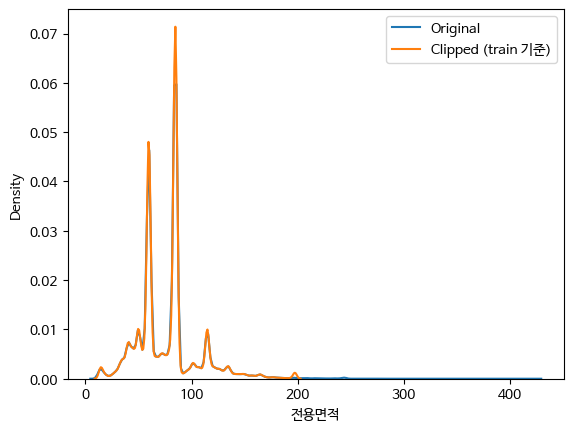

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(concat['전용면적'], label='Original')
sns.kdeplot(concat['전용면적_clip'], label='Clipped (train 기준)')
plt.legend()
plt.show()


In [13]:
concat.head(1)

,전용면적,층,target,is_test,contract_month,contract_date,covid,apt_age,구,동,전용면적_clip
0,79.97,3,124000.0,0,12,2018.0,0,38,강남구,개포동,79.97


In [19]:
print("Before clip:", concat[['전용면적', 'target']].corr().iloc[0,1])
print("After clip:", concat[['전용면적_clip', 'target']].corr().iloc[0,1])


Before clip: 0.5770410539850063
After clip: 0.5685892393801659


In [20]:
# categorical column name, numerical column name return function
cat_cols_f = []
num_cols_f = []

def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

# update and check variable
cat_cols_f, num_cols_f = split_categorical_numerical(concat)

📌 범주형 변수: ['구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'is_test', 'contract_month', 'contract_date', 'covid', 'apt_age', '전용면적_clip']


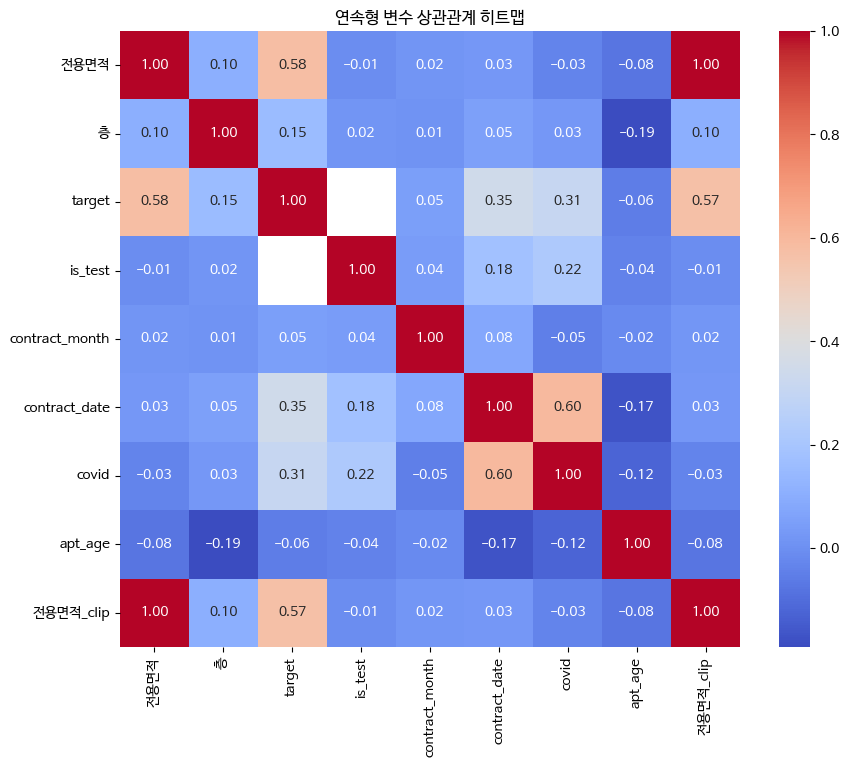

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(concat[num_cols_f].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("연속형 변수 상관관계 히트맵")
plt.show()

In [23]:
concat = concat.drop(columns = ['전용면적'])

In [26]:
# categorical column name, numerical column name return function
cat_cols_f2 = []
num_cols_f2 = []

def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

# update and check variable
cat_cols_f2, num_cols_f2 = split_categorical_numerical(concat)

📌 범주형 변수: ['구', '동']
📌 연속형 변수: ['층', 'target', 'is_test', 'contract_month', 'contract_date', 'covid', 'apt_age', '전용면적_clip']


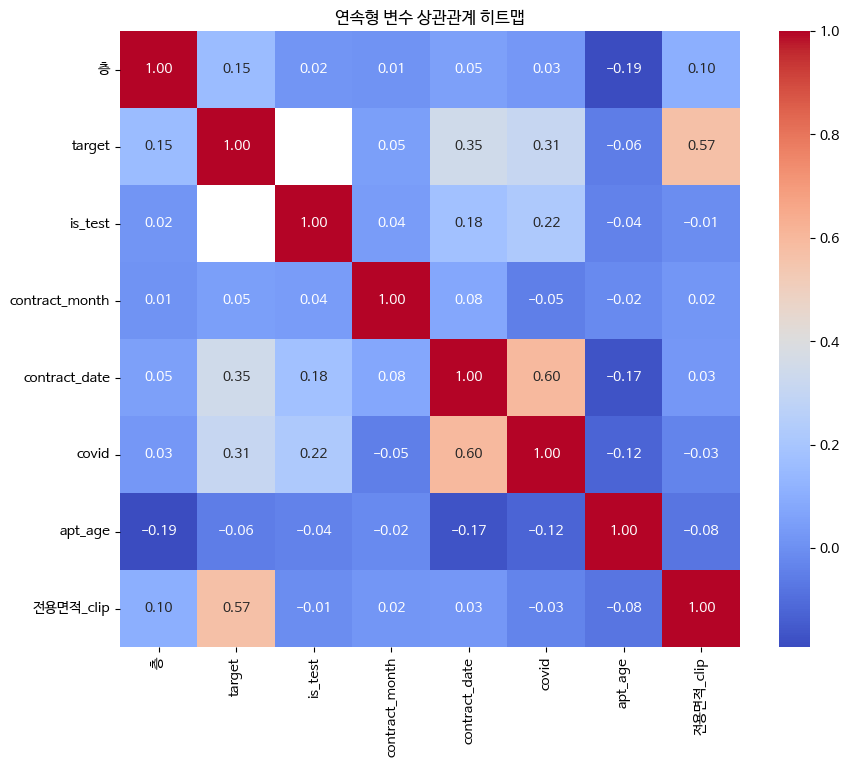

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(concat[num_cols_f2].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("연속형 변수 상관관계 히트맵")
plt.show()

In [28]:
# train set, test set split
df_train = concat.query('is_test == 0')
df_test = concat.query('is_test == 1')

# 이제 is_test 칼럼은 drop해줍니다.
df_train.drop(['is_test'], axis = 1, inplace=True)
df_test.drop(['is_test'], axis = 1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 9) (9272, 9)


In [29]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( cat_cols ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


In [30]:
# Target과 독립변수들을 분리해줍니다.
y_train = np.log1p(df_train['target'])
X_train = df_train.drop(['target'], axis=1)
df_test.drop(axis = 1, columns=['target'], inplace = True)

In [31]:
X_train.head()

,층,contract_month,contract_date,covid,apt_age,구,동,전용면적_clip
0,3,12,2018.000000,0,38,0,8,79.97
1,4,12,2018.000000,0,38,0,8,79.97
2,5,12,2018.000000,0,38,0,8,54.98
3,4,1,2018.083333,0,38,0,8,79.97
4,2,1,2018.083333,0,38,0,8,79.97


In [32]:
# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [33]:
import time

start = time.time()

model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

end = time.time()
print(f"⏱ 실행 시간: {end - start:.2f}초")

⏱ 실행 시간: 3.42초


In [34]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 0.10735634997701934


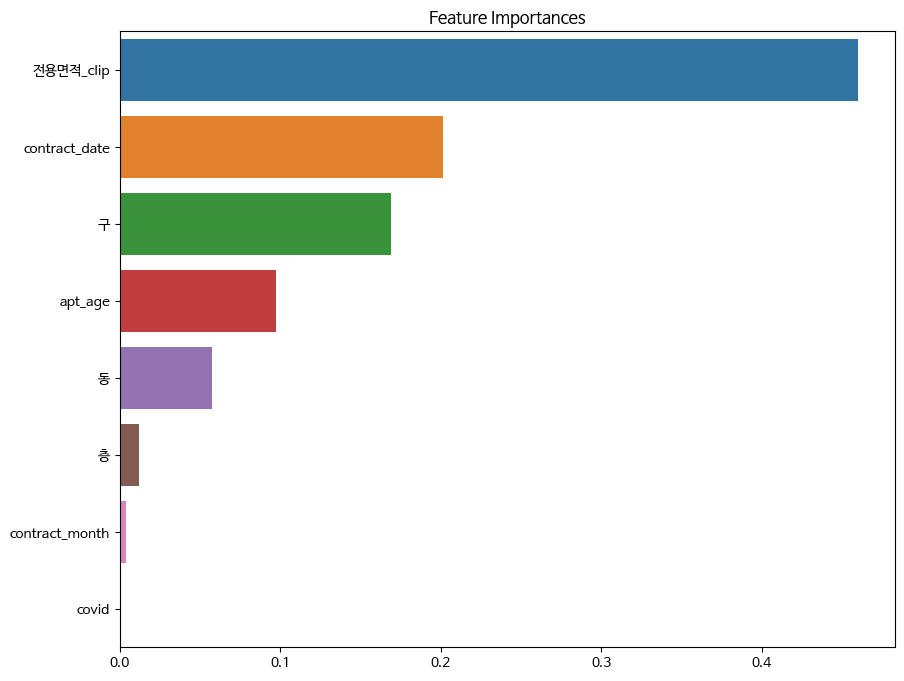

In [35]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [36]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model_ke_by_sh', 'wb') as f:
    pickle.dump(model, f)

In [37]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)

eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
0.3363 ± 0.0013,전용면적_clip
0.2058 ± 0.0006,구
0.1782 ± 0.0005,contract_date
0.0977 ± 0.0002,apt_age
0.0642 ± 0.0007,동
0.0055 ± 0.0001,층
0.0003 ± 0.0000,contract_month
0.0000 ± 0.0000,covid


In [38]:
# valid prediction

# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [39]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [40]:
# inference

# 저장된 모델을 불러옵니다.
with open('saved_model_ke_by_sh', 'rb') as f:
    model = pickle.load(f)

In [49]:
%%time
X_test = df_test
# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 21.5 ms, sys: 0 ns, total: 21.5 ms
Wall time: 16 ms


In [50]:
# 예측값을 log1p로 학습했으니, expm1로 다시 복원해야 함
y_pred_test = np.expm1(real_test_pred)


In [ ]:
len(y_pred_test)

9272

In [52]:
submission = pd.DataFrame(y_pred_test.astype(int), columns=['target'])
submission.to_csv('sub_250716_rf_ksh.csv', index=False)